In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/customer-segmentation/customer_segmentation.csv')

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
df['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [6]:
df['Education'].value_counts()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [7]:
df.duplicated().sum()

0

# Feature Engineering

The age of clients as of 2014, which is our the latest year of this dataset

In [8]:
df['Age']= 2014-df['Year_Birth']

The total amount spent on all 6 categories

In [9]:
df['Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

Tidying up the marriage sections as people filled out the forms

In [10]:
df['relationship_status'] = df['Marital_Status'].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Single", "Widow":"Single", "YOLO":"Single", "Divorced":"Single", "Single":"Single", "Alone":"Single"})

Tracking households with children

In [11]:
df['Children'] = df['Kidhome'] + df['Teenhome']

Tracking family size

In [12]:
df['Family_size'] = df['relationship_status'].replace({"Single": 1, "Partner": 2}) + df['Children']

Also going to track weather people are parents or not

In [13]:
df['Is_parent'] = np.where(df.Children > 0, 1, 0)

Cleaning up educational features

In [14]:
df['Education'] = df['Education'].replace({"Basic":"Undergrad", "2n Cycle":"Undergrad", "Graduation":"Graduate", "Master":"Postgrad", "PhD":"Postgrad"})

Dropping the useless features

In [15]:
df = df.drop(columns = ['Marital_Status', 'Dt_Customer', 'ID', 'Year_Birth', 'Z_CostContact', 'Z_Revenue'], axis = 1)

In [16]:
df.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,relationship_status,Children,Family_size,Is_parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,Single,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,Single,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,Partner,1,3,1
4,Postgrad,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,Partner,1,3,1


In [17]:
new_column_names = [
    'education', 'income', 'kidhome', 'teenhome', 'recency', 'mnt_wines', 'mnt_fruits',
    'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods',
    'num_deals_purchases', 'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases',
    'num_web_visits_month', 'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1',
    'accepted_cmp2', 'complain', 'response', 'age', 'spent', 'relationship_status',
    'children', 'family_size', 'is_parent'
]

df.columns = new_column_names
df.head()

,education,income,kidhome,teenhome,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,age,spent,relationship_status,children,family_size,is_parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,Single,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,Single,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,Partner,1,3,1
4,Postgrad,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,Partner,1,3,1


# EDA

In [18]:
summary = df.describe().T
rounded_summary = summary.round(2)
rounded_summary

,count,mean,std,min,25%,50%,75%,max
income,2216.0,52247.25,25173.08,1730.0,35303.00,51381.5,68522.00,666666.0
kidhome,2240.0,0.44,0.54,0.0,0.00,0.0,1.00,2.0
teenhome,2240.0,0.51,0.54,0.0,0.00,0.0,1.00,2.0
recency,2240.0,49.11,28.96,0.0,24.00,49.0,74.00,99.0
mnt_wines,2240.0,303.94,336.60,0.0,23.75,173.5,504.25,1493.0
mnt_fruits,2240.0,26.30,39.77,0.0,1.00,8.0,33.00,199.0
mnt_meat_products,2240.0,166.95,225.72,0.0,16.00,67.0,232.00,1725.0
mnt_fish_products,2240.0,37.53,54.63,0.0,3.00,12.0,50.00,259.0
mnt_sweet_products,2240.0,27.06,41.28,0.0,1.00,8.0,33.00,263.0
mnt_gold_prods,2240.0,44.02,52.17,0.0,9.00,24.0,56.00,362.0


In [19]:
num_cat = df[['income', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods', 'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month', 'age', 'spent']]

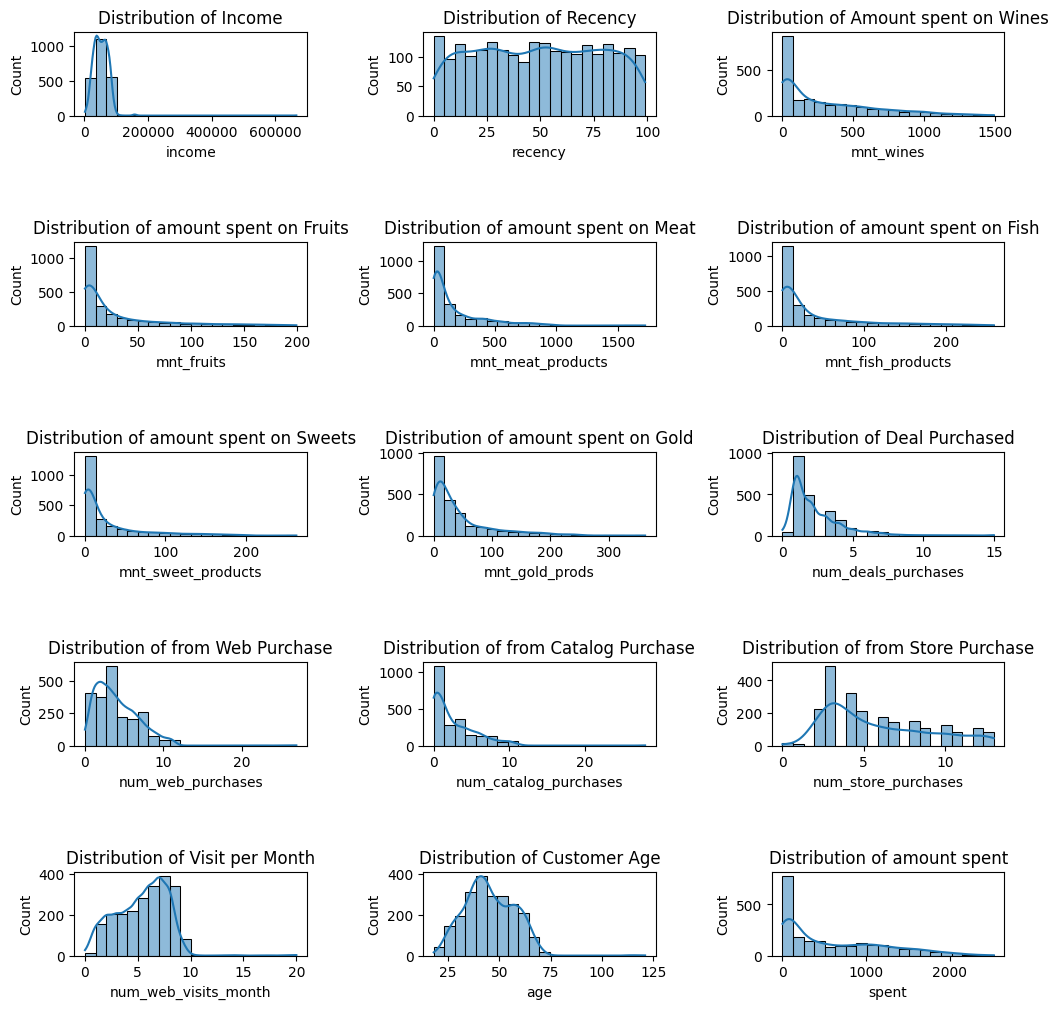

In [20]:
plt.figure(figsize = (12, 12))
plt.subplots_adjust(hspace = 1.5, wspace=0.5)

plt.subplot(5, 3, 1)
sns.histplot(df, x = 'income', kde = True, bins = 20)
plt.title("Distribution of Income")

plt.subplot(5, 3, 2)
sns.histplot(df, x = 'recency', kde = True, bins = 20)
plt.title("Distribution of Recency")

plt.subplot(5, 3, 3)
sns.histplot(df, x = "mnt_wines", kde = True, bins = 20)
plt.title("Distribution of Amount spent on Wines")

plt.subplot(5, 3, 4)
sns.histplot(df, x = 'mnt_fruits', kde = True, bins = 20)
plt.title("Distribution of amount spent on Fruits")

plt.subplot(5, 3, 5)
sns.histplot(df, x = 'mnt_meat_products', kde = True, bins = 20)
plt.title("Distribution of amount spent on Meat")

plt.subplot(5, 3, 6)
sns.histplot(df, x = 'mnt_fish_products', kde = True, bins = 20)
plt.title("Distribution of amount spent on Fish")

plt.subplot(5, 3, 7)
sns.histplot(df, x = 'mnt_sweet_products', kde = True, bins = 20)
plt.title("Distribution of amount spent on Sweets")

plt.subplot(5, 3, 8)
sns.histplot(df, x = 'mnt_gold_prods', kde = True, bins = 20)
plt.title("Distribution of amount spent on Gold")

plt.subplot(5, 3, 9)
sns.histplot(df, x = 'num_deals_purchases', kde = True, bins = 20)
plt.title("Distribution of Deal Purchased")

plt.subplot(5, 3, 10)
sns.histplot(df, x = 'num_web_purchases', kde = True, bins = 20)
plt.title("Distribution of from Web Purchase")

plt.subplot(5, 3, 11)
sns.histplot(df, x = 'num_catalog_purchases', kde = True, bins = 20)
plt.title("Distribution of from Catalog Purchase")

plt.subplot(5, 3, 12)
sns.histplot(df, x = 'num_store_purchases', kde = True, bins = 20)
plt.title("Distribution of from Store Purchase")

plt.subplot(5, 3, 13)
sns.histplot(df, x = 'num_web_visits_month', kde = True, bins = 20)
plt.title("Distribution of Visit per Month")

plt.subplot(5, 3, 14)
sns.histplot(df, x = 'age', kde = True, bins = 20)
plt.title("Distribution of Customer Age")

plt.subplot(5, 3, 15)
sns.histplot(df, x = 'spent', kde = True, bins = 20)
plt.title("Distribution of amount spent")

plt.show()

In [21]:
df = df[(df["age"]<90)]
df = df[(df["income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2212


In [22]:
cat_cat = df[['children', 'family_size', 'is_parent', 'education', 'accepted_cmp1','accepted_cmp2','accepted_cmp3','accepted_cmp4','complain','response','relationship_status']]

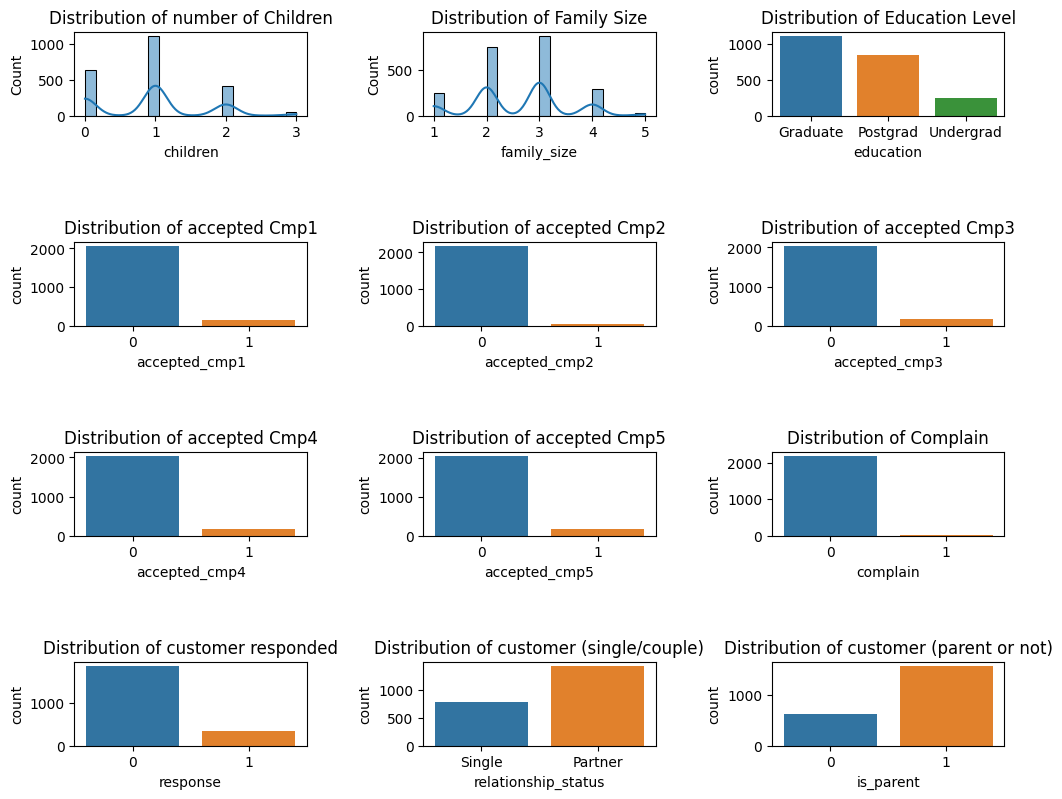

In [23]:
plt.figure(figsize = (12, 12))
plt.subplots_adjust(hspace = 1.5, wspace=0.5)

plt.subplot(5, 3, 1)
sns.histplot(df, x = 'children', kde = True, bins = 20)
plt.title("Distribution of number of Children")

plt.subplot(5, 3, 2)
sns.histplot(df, x = 'family_size', kde = True, bins = 20)
plt.title('Distribution of Family Size')

plt.subplot(5, 3, 3)
sns.countplot(df, x = 'education')
plt.title("Distribution of Education Level")

plt.subplot(5, 3, 4)
sns.countplot(df, x = 'accepted_cmp1')
plt.title("Distribution of accepted Cmp1")

plt.subplot(5, 3, 5)
sns.countplot(df, x = 'accepted_cmp2')
plt.title("Distribution of accepted Cmp2")

plt.subplot(5, 3, 6)
sns.countplot(df, x = 'accepted_cmp3')
plt.title("Distribution of accepted Cmp3")

plt.subplot(5, 3, 7)
sns.countplot(df, x = 'accepted_cmp4')
plt.title("Distribution of accepted Cmp4")

plt.subplot(5, 3, 8)
sns.countplot(df, x = 'accepted_cmp5')
plt.title("Distribution of accepted Cmp5")

plt.subplot(5, 3, 9)
sns.countplot(df, x = 'complain')
plt.title('Distribution of Complain')

plt.subplot(5, 3, 10)
sns.countplot(df, x = 'response')
plt.title('Distribution of customer responded')

plt.subplot(5, 3, 11)
sns.countplot(df, x = 'relationship_status')
plt.title("Distribution of customer (single/couple)")

plt.subplot(5, 3, 12)
sns.countplot(df, x = 'is_parent')
plt.title("Distribution of customer (parent or not)")

plt.show()

In [24]:
a = (df.dtypes == 'object')
object_cols = list(a[a].index)
print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['education', 'relationship_status']


In [25]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
for i in object_cols:
  df[i] = df[[i]].apply(LE.fit_transform)

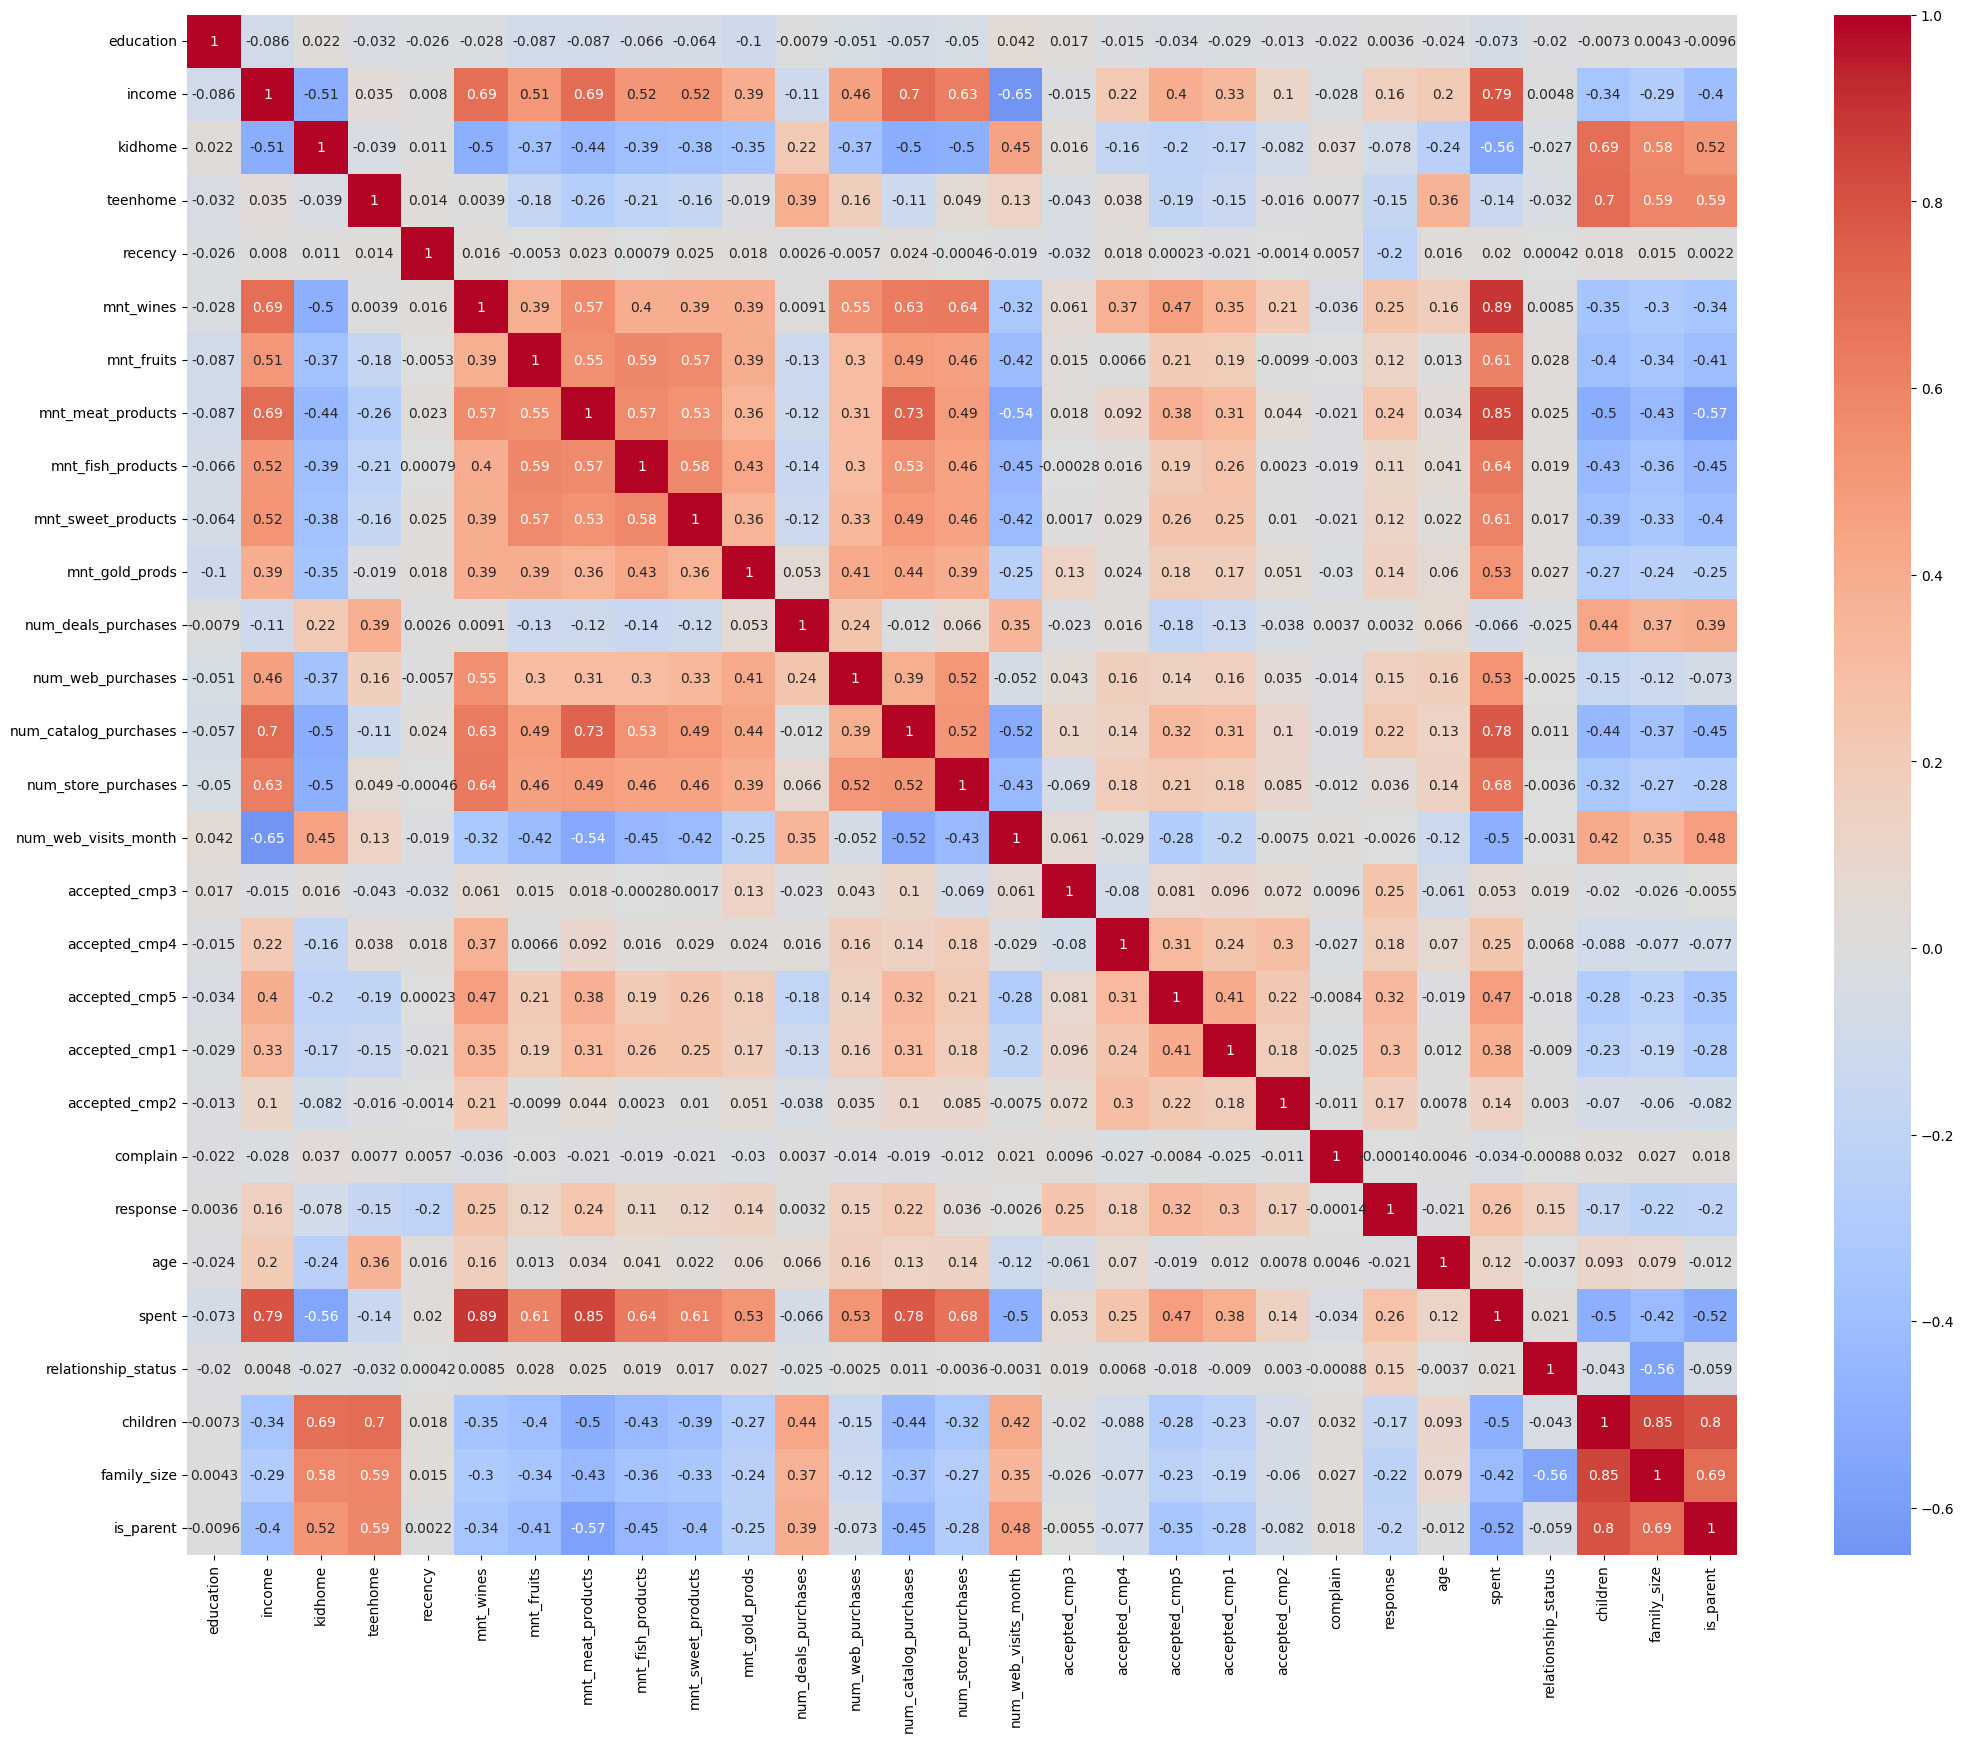

In [26]:
corrmax = df.corr()
plt.figure(figsize = (25, 20))
sns.heatmap(corrmax, annot = True, cmap = 'coolwarm', center = 0)
plt.show()

# Clustering

In [27]:
from sklearn.preprocessing import StandardScaler
df1 = df.copy()
scaler = StandardScaler()
scaler.fit(df1)
scaled_df1 = pd.DataFrame(scaler.transform(df1), columns = df1.columns)

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df1)
scaled_df1 = pd.DataFrame(scaler.transform(df1), columns = df1.columns)

## Scaling

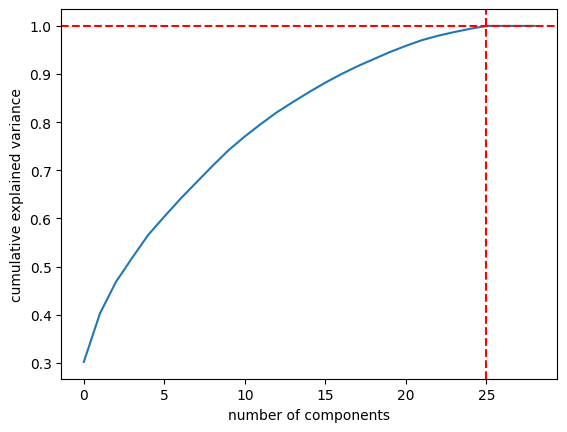

In [29]:
from sklearn.decomposition import PCA


pca = PCA().fit(scaled_df1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=25, color='r', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [30]:
pca = PCA(n_components = 25, random_state = 0, svd_solver = 'full')
pca.fit(scaled_df1)
df1_reduced = pd.DataFrame(pca.transform(scaled_df1), columns = (['col1', 'col2', 'col3', 'col4',
                                                                  'col5', 'col6', 'col7', 'col8',
                                                                  'col9', 'col10', 'col11', 'col12',
                                                                  'col13', 'col14', 'col15', 'col16',
                                                                  'col17', 'col18', 'col19','col20','col21',
                                                                  'col22','col23','col24','col25']))

In [31]:
df1_reduced

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25
0,4.883833,-0.550251,-0.228665,2.409819,-1.369812,0.292551,0.702387,-0.271318,-0.126838,0.136903,-1.008656,-1.100510,2.371811,-1.178552,0.190067,-0.106251,0.322144,-0.711621,1.311200,0.666670,-0.372661,0.274446,0.661453,-0.165102,0.602500
1,-2.898136,0.205609,-0.186165,-0.572153,-0.676133,-1.034965,2.039501,-0.727831,-0.815401,-0.268246,0.072337,-0.085092,0.285824,0.094459,0.105280,-0.011259,-0.633787,0.046241,0.115407,0.169720,0.201333,0.099168,-0.033570,-0.173129,0.184197
2,2.376005,-0.693265,-1.202838,-0.383997,-0.269172,-0.179231,-0.779013,-0.426240,0.618761,1.736998,-0.218864,-0.102656,-0.255255,-0.294394,-0.488405,0.547323,-0.517368,-0.711219,-0.905987,-0.243179,-0.625848,0.998782,-0.387673,-0.296498,0.523268
3,-2.683299,-1.347597,0.045790,0.184290,1.143676,0.498018,-0.114560,-0.966783,0.220332,1.050917,0.076701,0.493057,-0.241516,0.146337,-0.254125,0.045037,-0.141910,-0.032198,-0.252294,0.009981,-0.098190,-0.001081,0.287481,0.005755,-0.272306
4,-0.767220,0.264229,-0.658528,0.407098,1.206903,1.841525,-0.629259,0.375399,0.003776,-0.973818,-0.026005,0.258640,0.614612,-0.140197,-0.390215,0.051818,0.269789,0.075661,-0.780940,-0.239473,0.226184,0.821426,0.561880,-0.356768,-0.341508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,2.079904,2.364331,-1.208664,1.201433,0.157522,0.416293,-0.180628,0.591293,-0.155478,1.781995,0.292749,-1.198770,-1.141472,0.677834,2.018262,-0.000753,0.194328,-0.116612,0.771474,1.743465,1.232668,-0.812967,-0.337222,-0.865725,-0.550405
2208,-2.501688,4.219240,1.544097,0.004745,1.812603,-0.251288,0.266631,-0.447285,-0.459111,-1.682624,-1.738767,-2.107341,0.745521,1.839176,-1.994835,0.592668,-1.451127,-0.516580,-1.185942,-0.168579,1.082053,0.694237,-0.504499,-0.536096,0.605105
2209,2.758805,-1.341919,0.934838,-1.633382,-1.945431,2.892999,0.262382,-0.104188,0.262747,0.197134,-0.217304,1.237198,-0.893425,-1.360358,-0.604257,-1.869978,-0.575488,-0.294916,-0.583460,-1.124337,-0.428875,-1.426476,-0.517027,-0.010302,0.763072
2210,1.303674,1.819886,-1.168572,-0.610280,-0.112850,-1.662275,-0.912384,-0.534582,0.273717,0.229952,0.557573,0.182139,-0.249336,0.306860,-0.087073,-0.007828,-0.193298,-0.319331,-0.187448,0.160527,-0.392937,0.142721,0.573742,0.360158,-0.170346


## Dimension Reduction

In [32]:
X = df1_reduced.iloc[:,:].values

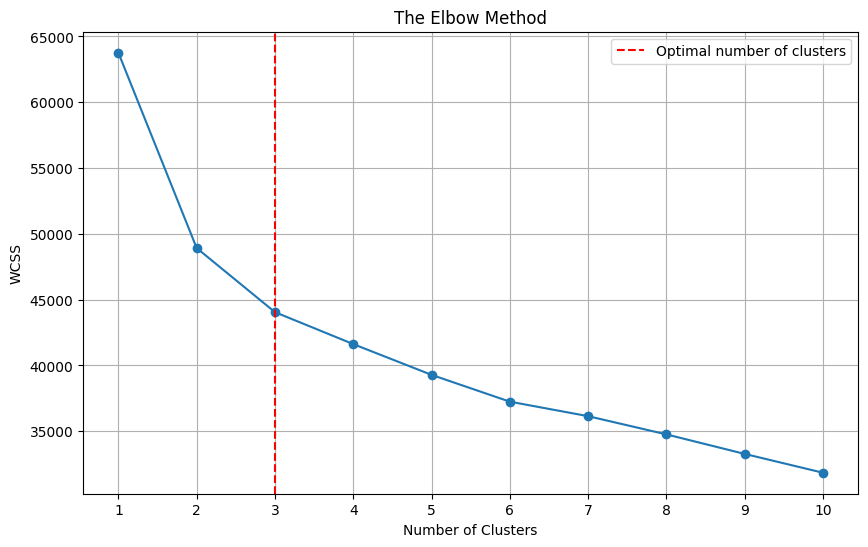

In [33]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.axvline(x=3, color='red', linestyle='--', label='Optimal number of clusters')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()

In [34]:
kmeans = KMeans(n_clusters= 3, random_state=0)
cluster_labels = kmeans.fit_predict(df1_reduced)
df1['Cluster'] = cluster_labels
df1.to_excel('Clustered_data.xlsx', index = False)

In [35]:
df1.head()

,education,income,kidhome,teenhome,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,age,spent,relationship_status,children,family_size,is_parent,Cluster
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,1,0,1,0,0
1,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,1,2,3,1,1
2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,0,0,2,0,0
3,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,0,1,3,1,1
4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,0,1,3,1,1


In [36]:
df['Cluster'] = cluster_labels
df.head()

,education,income,kidhome,teenhome,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,age,spent,relationship_status,children,family_size,is_parent,Cluster
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,1,0,1,0,0
1,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,1,2,3,1,1
2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,0,0,2,0,0
3,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,0,1,3,1,1
4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,0,1,3,1,1


In [37]:
df['Cluster'] = df['Cluster'].replace({0: 1, 1: 0})


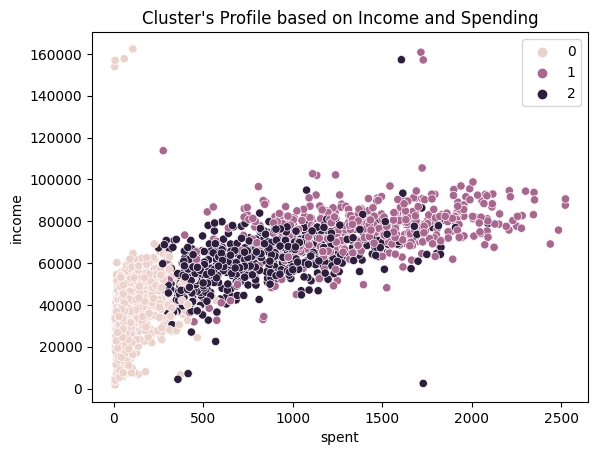

In [38]:
sns.scatterplot(df, x = 'spent', y = 'income', hue = 'Cluster')
plt.title("Cluster's Profile based on Income and Spending")
plt.legend()
plt.show()

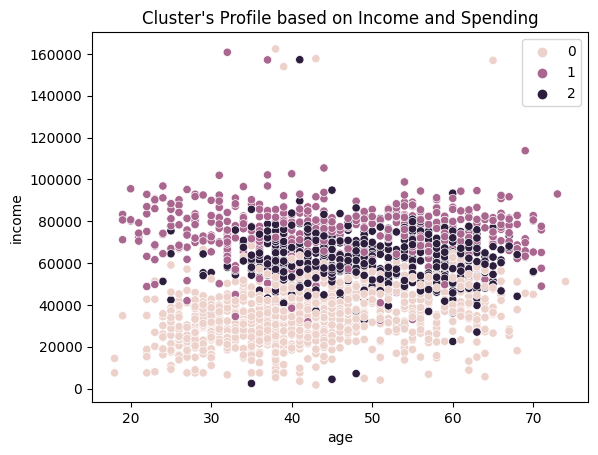

In [39]:
sns.scatterplot(df, x = 'age', y = 'income', hue = 'Cluster')
plt.title("Cluster's Profile based on Income and Spending")
plt.legend()
plt.show()

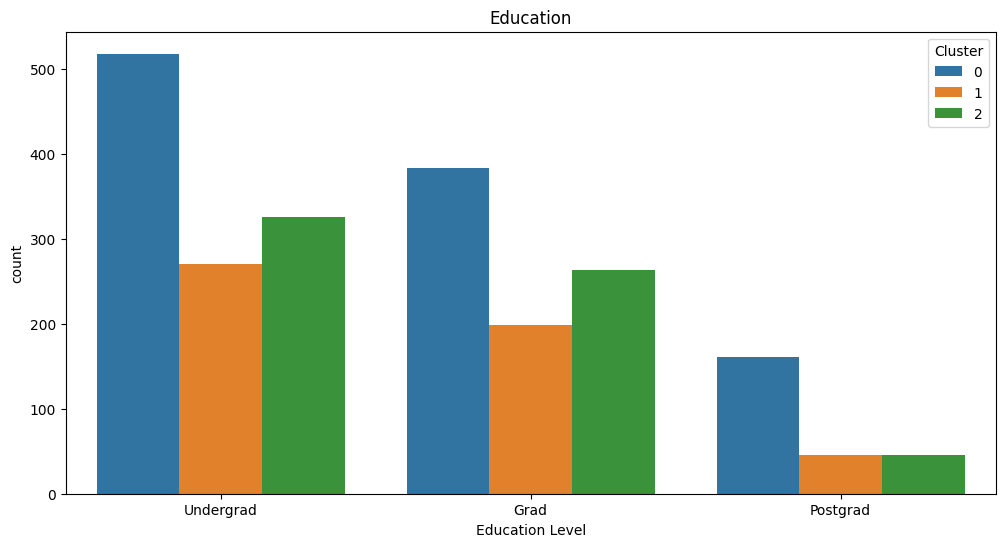

In [40]:
df['education'] = df['education'].replace({0: 'Undergrad', 1: 'Grad', 2: 'Postgrad'})

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='education', hue='Cluster')
plt.title("Education")
plt.xlabel("Education Level")
plt.show()

In [41]:
df['education'] = df['education'].replace({'Undergrad': 0, 'Grad': 1, 'Postgrad': 2})

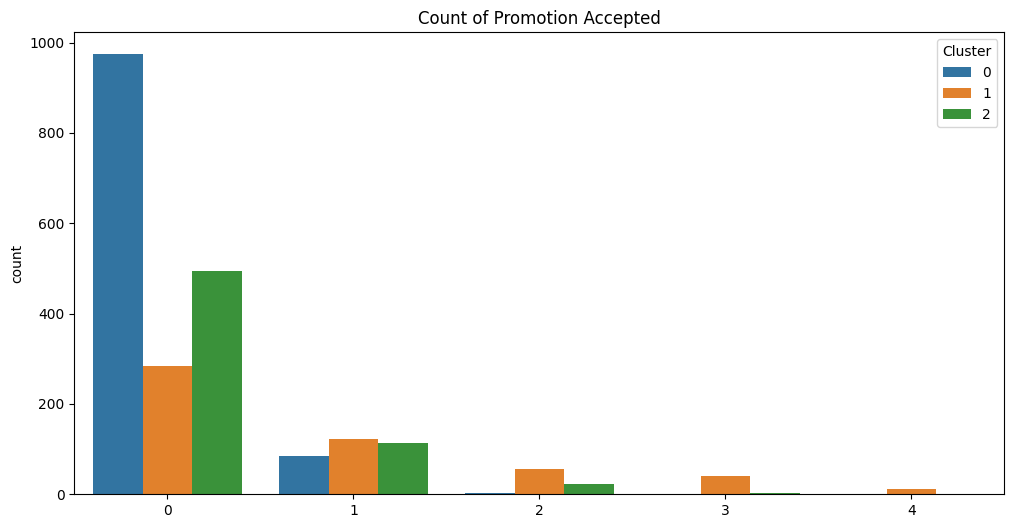

In [42]:
df['Total_promos'] = df['accepted_cmp1'] + df['accepted_cmp2'] + df['accepted_cmp3'] + df['accepted_cmp4'] + df['accepted_cmp5']

plt.figure(figsize = (12, 6))
sns.countplot(df, x = 'Total_promos', hue = 'Cluster')
plt.title("Count of Promotion Accepted")
plt.xlabel("")
plt.show()

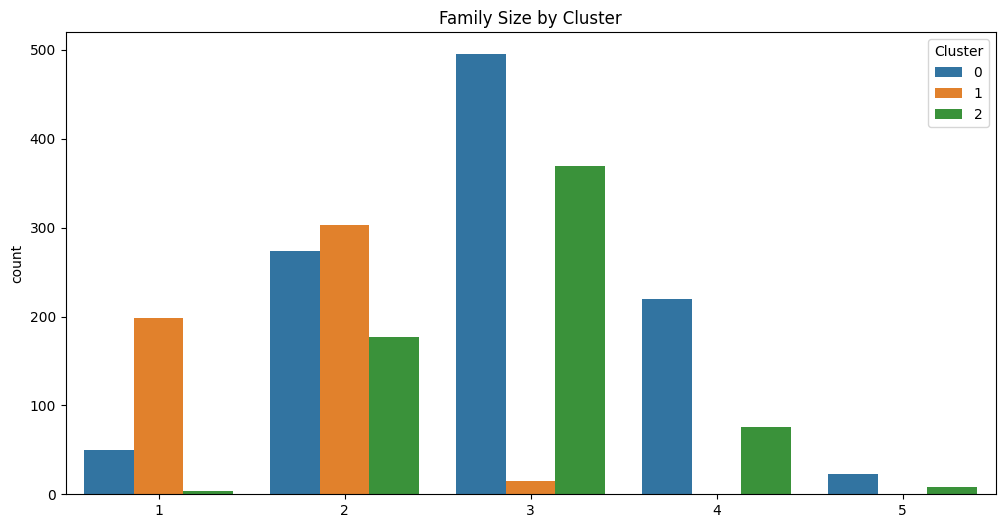

In [43]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='family_size', hue='Cluster')
plt.title("Family Size by Cluster")
plt.xlabel("")
plt.show()

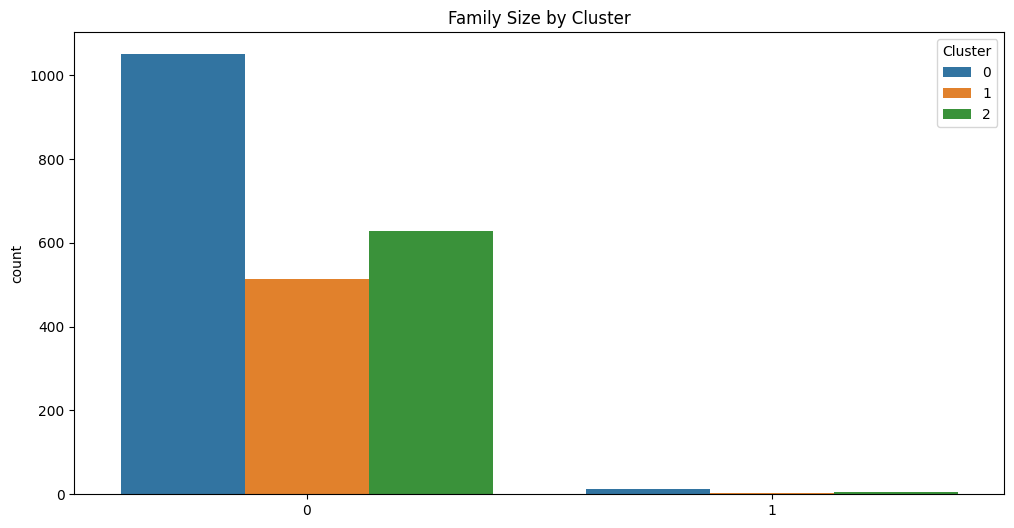

In [44]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='complain', hue='Cluster')
plt.title("Family Size by Cluster")
plt.xlabel("")
plt.show()

In [45]:
df['education'] = df['education'].replace({'Undergrad': 0, 'Grad': 1, 'Postgrad': 2})

In [46]:
df.head()

,education,income,kidhome,teenhome,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,age,spent,relationship_status,children,family_size,is_parent,Cluster,Total_promos
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,1617,1,0,1,0,1,0
1,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,27,1,2,3,1,0,0
2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,776,0,0,2,0,1,0
3,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,53,0,1,3,1,0,0
4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,422,0,1,3,1,0,0


In [49]:
df.to_csv('Project_6.csv', index=False)

print("CSV file has been saved.")
from IPython.display import FileLink
display(FileLink('Project_6.csv'))

CSV file has been saved.


/kaggle/working/Project_6.csv